# Voice Activity Detection

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/vad](https://github.com/huseinzol05/malaya-speech/tree/master/example/vad).
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline

In [2]:
y, sr = malaya_speech.utils.read.flac('speech/7021-79759-0004.flac')
len(y), sr

(391520, 16000)

### Load WebRTC

```python
def webrtc(
    aggressiveness: int = 3,
    sample_rate: int = 16000,
    minimum_amplitude: int = 100,
):
    """
    Load WebRTC VAD model.

    Parameters
    ----------
    aggressiveness: int, optional (default=3)
        an integer between 0 and 3.
        0 is the least aggressive about filtering out non-speech, 3 is the most aggressive.
    sample_rate: int, optional (default=16000)
        sample rate for samples.
    minimum_amplitude: int, optional (default=100)
        minimum_amplitude to assume a sample is a voice activity. Else, automatically False.

    Returns
    -------
    result : malaya_speech.model.webrtc.WEBRTC class
    """
```

WebRTC developed by Google, reportedly one of the best available, being fast, modern and free. Read more about pywebrtc at https://github.com/wiseman/py-webrtcvad.

In [3]:
vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))

### List available deep model

In [4]:
malaya_speech.vad.available_model()

,Size (MB),Accuracy
vggvox-v1,70.8,0.000000
vggvox-v2,31.1,0.959375


### Load deep model

Deep model trained on different noises, augmented noises, procedural noises, overlapped noises and actual voices.

In [5]:
model = malaya_speech.vad.deep_model()

### How to detect Voice Activity

In order to use available Malaya-Speech VAD models, we need to split our audio sample into really small chunks. 

For Google WebRTC, we need to split by every 30 ms. For deep learning, we trained on 30 ms, 90 ms and random length less than 300 ms.

To split an audio sample by giving time split, use, [malaya_speech.utils.generator.frames]()

```python
def frames(
    audio,
    frame_duration_ms: int = 30,
    sample_rate: int = 16000,
    append_ending_trail: bool = True,
):
    """
    Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and the sample rate.

    Parameters
    ----------

    audio: np.array / list
    frame_duration_ms: int, optional (default=30)
    sample_rate: int, optional (default=16000)
    append_ending_trail: bool, optional (default=True)
        if True, will append last trail and this last trail might not same length as `frame_duration_ms`.

    Returns
    -------
    result: List[malaya_speech.model.frame.FRAME]
    """
```

In [6]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 1.29 ms, sys: 50 µs, total: 1.34 ms
Wall time: 1.35 ms


In [7]:
%%time

frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 16.7 ms, sys: 263 µs, total: 17 ms
Wall time: 17 ms


In [8]:
%%time

frames_deep = [(frame, model(malaya_speech.utils.astype.int_to_float(frame))) for frame in frames]

CPU times: user 52.2 s, sys: 13.2 s, total: 1min 5s
Wall time: 14.3 s


**To speedup, you can do pipeline batching to utilize parallel processing or use GPU or both**.

#### Batching pipeline

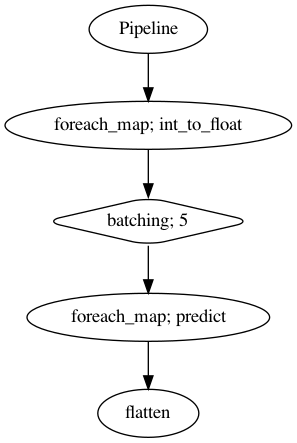

In [9]:
p = Pipeline()
pipeline = (
    p.foreach_map(malaya_speech.utils.astype.int_to_float)
    .batching(5)
    .foreach_map(model.predict)
    .flatten()
)
p.visualize()

In [10]:
%%time

result = p.emit(frames)
result.keys()

CPU times: user 47.7 s, sys: 9.21 s, total: 56.9 s
Wall time: 12.5 s


dict_keys(['int_to_float', 'batching', 'predict', 'flatten'])

In [11]:
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

`frames_deep` == `frames_deep_batch`.

### VAD Visualization

We can visualize our audio sample to annotate which parts are active speech or not.

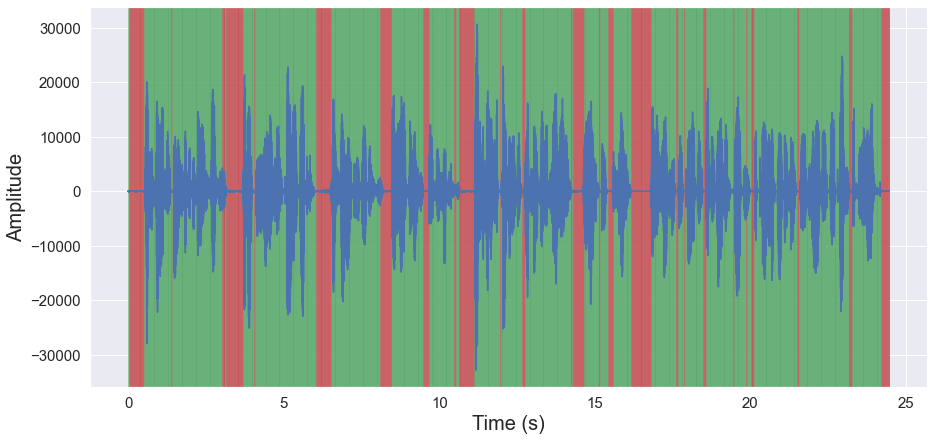

In [12]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

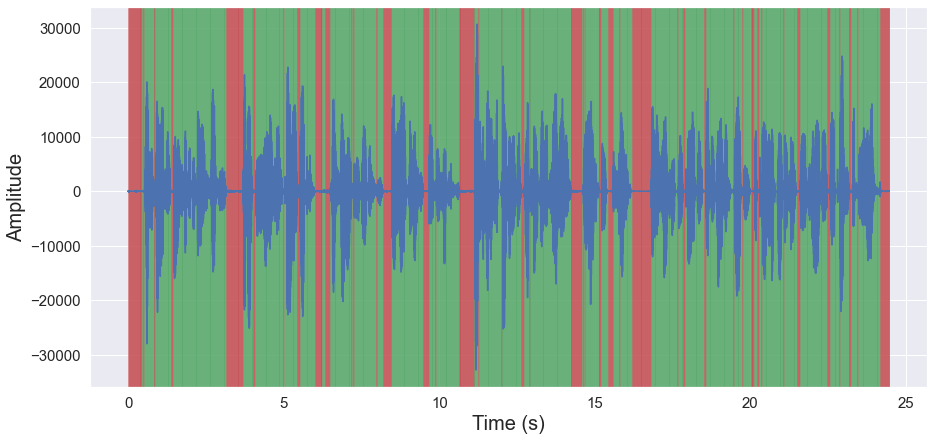

In [13]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep, sr)

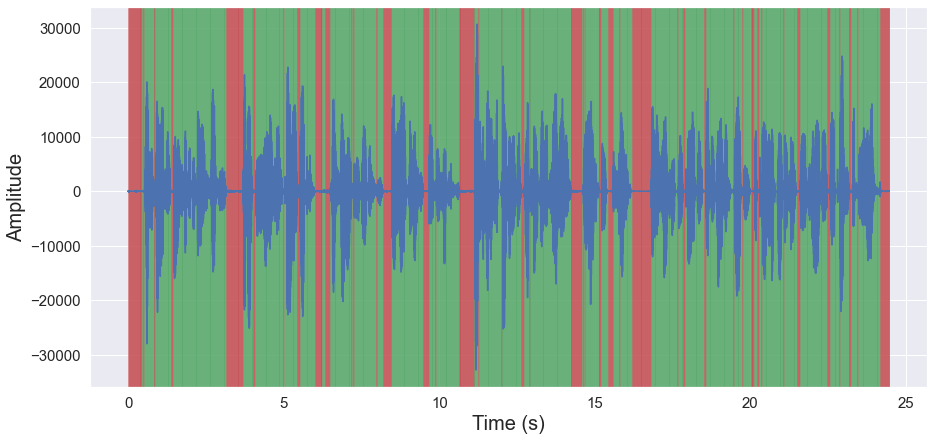

In [14]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

### Groupby VAD

To group small samples into larger samples, use [malaya_speech.utils.group.group_frames]()

In [15]:
grouped_vad = malaya_speech.utils.group.group_frames(frames_webrtc)
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep)

In [16]:
len(frames), len(grouped_vad), len(grouped_deep)

(816, 52, 83)

### Harder example

In the real world, not all samples recorded in clean cut studio, full with background noises, music and etc. So those are not the real voice activities. Lets take noise sound,

In [17]:
y, sr = malaya_speech.utils.read.wav('speech/noise/n98.wav')
len(y), sr

(64000, 16000)

In [18]:
%%time

frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

CPU times: user 165 µs, sys: 1 µs, total: 166 µs
Wall time: 169 µs


In [19]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 3.52 ms, sys: 772 µs, total: 4.3 ms
Wall time: 3.4 ms


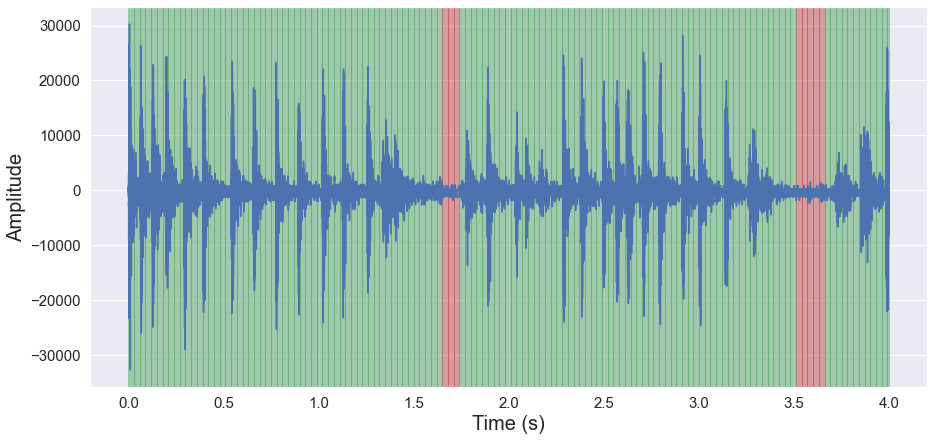

In [20]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [21]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 6.89 s, sys: 1.36 s, total: 8.25 s
Wall time: 2.07 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


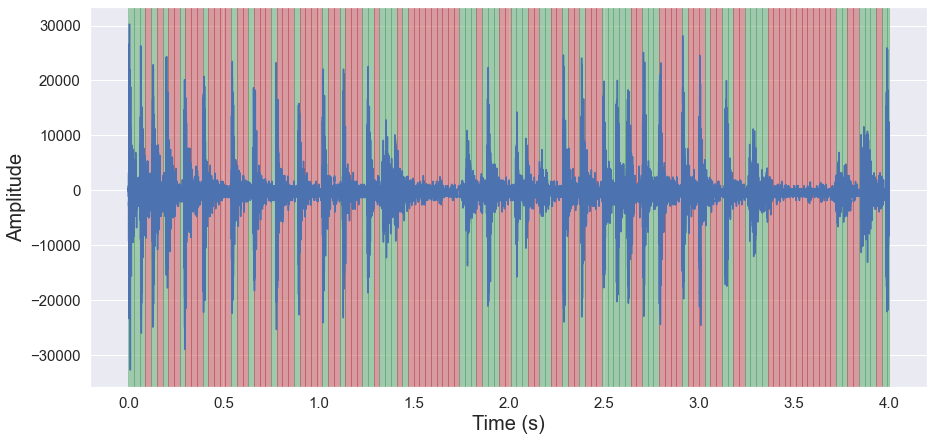

In [22]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

As you can see, the deep model able to know this sample mostly noises!

In [23]:
y, sr = malaya_speech.utils.read.wav('speech/podcast/2x5%20Ep%2010.wav')
y = y[: sr * 10]
len(y), sr

(160000, 16000)

In [24]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

In [25]:
%%time

vad = malaya_speech.vad.webrtc(minimum_amplitude = int(np.quantile(np.abs(y), 0.2)))
frames_webrtc = [(frame, vad(frame)) for frame in frames]

CPU times: user 12.1 ms, sys: 1.91 ms, total: 14 ms
Wall time: 12.5 ms


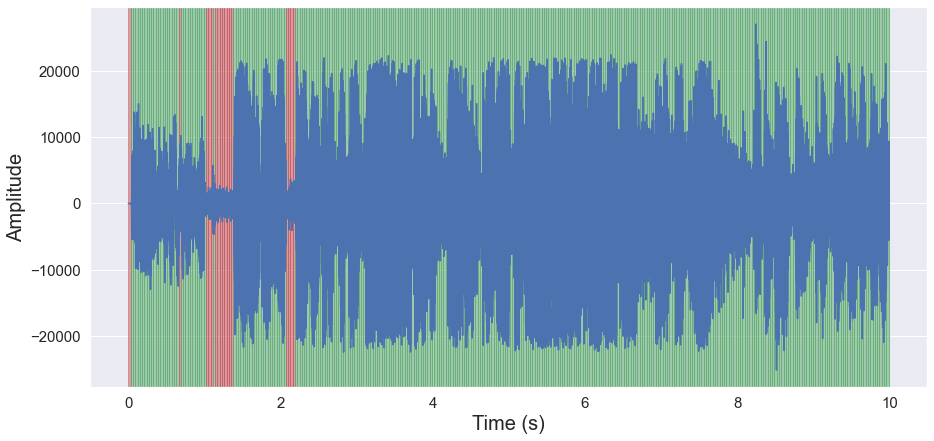

In [26]:
malaya_speech.extra.visualization.visualize_vad(y, frames_webrtc, sr)

In [27]:
%%time

result = p.emit(frames)
frames_deep_batch = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]

CPU times: user 17.9 s, sys: 3.43 s, total: 21.3 s
Wall time: 4.84 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=320
  n_fft, y.shape[-1]


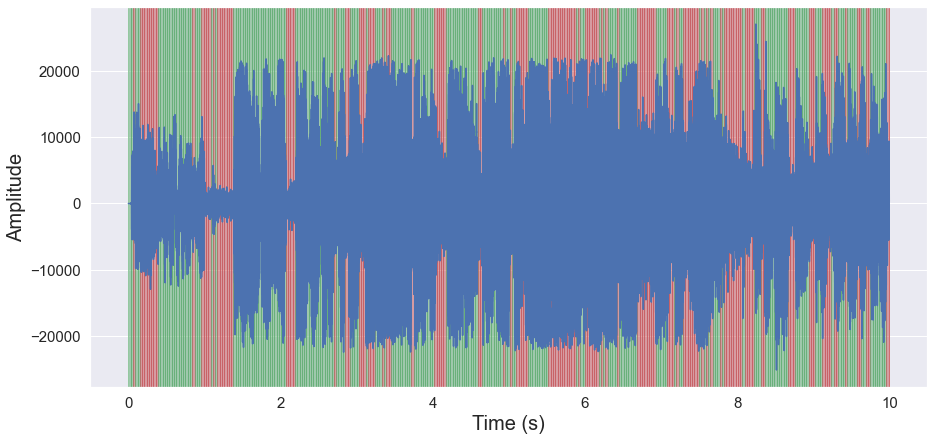

In [32]:
malaya_speech.extra.visualization.visualize_vad(y, frames_deep_batch, sr)

In [33]:
grouped_deep = malaya_speech.utils.group.group_frames(frames_deep_batch)

In [34]:
[(no, i[0].duration, i[1]) for no, i in enumerate(grouped_deep[:20])]

[(0, 0.06, True),
 (1, 0.03, False),
 (2, 0.06, True),
 (3, 0.24, False),
 (4, 0.4500000000000002, True),
 (5, 0.03, False),
 (6, 0.09, True),
 (7, 0.12, False),
 (8, 0.03, True),
 (9, 0.03, False),
 (10, 0.03, True),
 (11, 0.21, False),
 (12, 0.6900000000000004, True),
 (13, 0.12, False),
 (14, 0.5100000000000002, True),
 (15, 0.03, False),
 (16, 0.12, True),
 (17, 0.06, False),
 (18, 0.12, True),
 (19, 0.09, False)]

Now we are going to listen 4, 12, 14, those durations longer than others.

In [35]:
import IPython.display as ipd
ipd.Audio(grouped_deep[4][0].array, rate = sr)

In [36]:
ipd.Audio(grouped_deep[12][0].array, rate = sr)

In [37]:
ipd.Audio(grouped_deep[14][0].array, rate = sr)